In [ ]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
)
from ad_ied.replay import replay_run, explained_variance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
from matplotlib.ticker import AutoMinorLocator
from statannotations.Annotator import Annotator
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
# import seaborn.objects as so

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'D:\github\ad_ied\results'


In [2]:
df = pd.read_csv(r"D:\github\ad_ied\data\sessions.csv")
df.head()

,Unnamed: 0,basepath
0,0,X:\AD_sessions\AZ10\AZ10_210317_sess2
1,1,X:\AD_sessions\AZ10\AZ10_210322_sess4
2,2,X:\AD_sessions\AZ10\AZ10_210324_sess5
3,3,X:\AD_sessions\AZ10\AZ10_210329_sess6
4,4,X:\AD_sessions\AZ10\AZ10_210412_sess9


In [67]:
save_path = r"D:\github\ad_ied\results\explained_variance_v3"
batch_analysis.run(
    df,
    save_path,
    explained_variance.run,
    parallel=True,
    verbose=False,
    task_binsize=0.500
)
ev_df, pairwise_corr_df = explained_variance.load_results(save_path)

100%|██████████| 29/29 [00:00<00:00, 106.70it/s]


In [68]:
pairwise_corr_df.head()

,corrcoef,epoch,event,ref_uid,target_uid,basepath
0,NaN,pre,ripples_pre_ied,1,1,X:\AD_sessions\AZ10\AZ10_210317_sess2
1,NaN,pre,ripples_pre_ied,1,2,X:\AD_sessions\AZ10\AZ10_210317_sess2
2,0.080078,pre,ripples_pre_ied,1,3,X:\AD_sessions\AZ10\AZ10_210317_sess2
3,0.165479,pre,ripples_pre_ied,1,4,X:\AD_sessions\AZ10\AZ10_210317_sess2
4,0.252409,pre,ripples_pre_ied,1,5,X:\AD_sessions\AZ10\AZ10_210317_sess2


<AxesSubplot: xlabel='epoch', ylabel='corrcoef'>

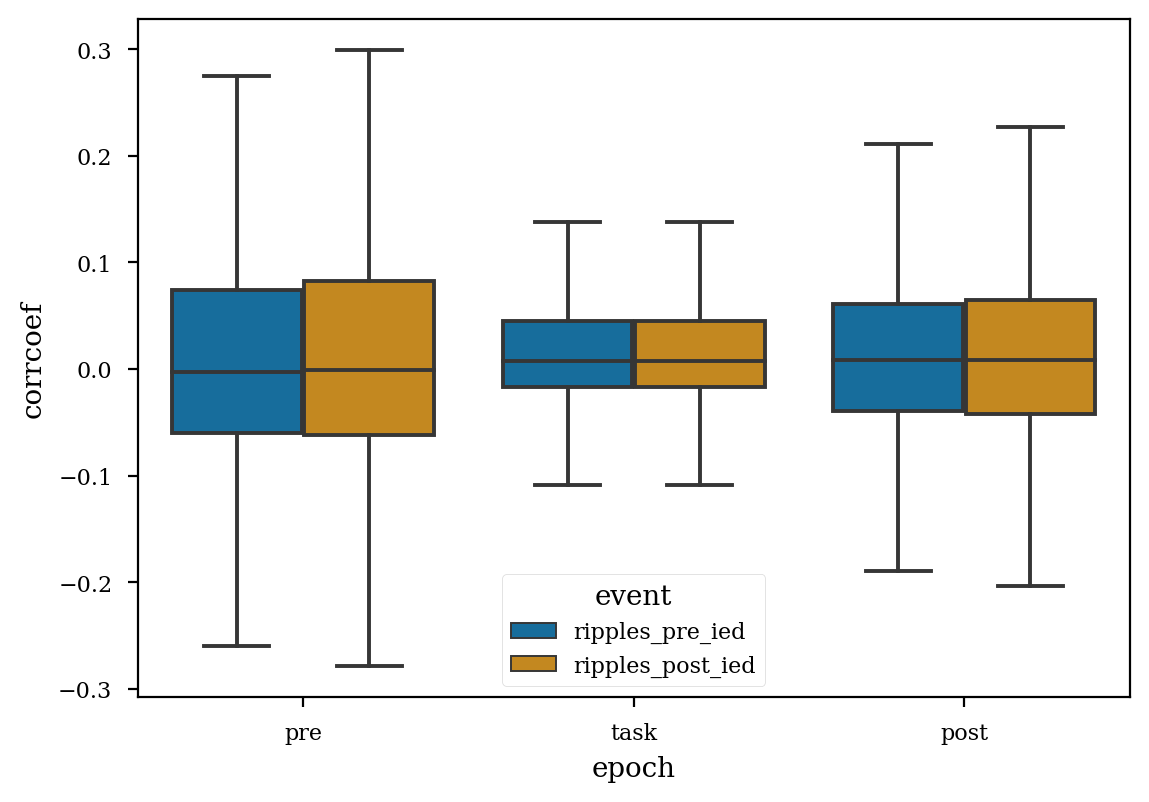

In [69]:
sns.boxplot(
    data=pairwise_corr_df,
    x="epoch",
    y="corrcoef",
    hue="event",
    palette="colorblind",
    showfliers=False,
)

In [70]:

ev_df["ev_norm"] = (ev_df.ev - ev_df.rev) / (ev_df.ev + ev_df.rev)
ev_df.head()

,region,events,ev,rev,n_cells,n_pre_events,n_task_events,n_post_events,basepath,ev_norm
0,NaN,ripples_pre_ied,0.000731,0.007104,37,337,3373,84,X:\AD_sessions\AZ10\AZ10_210317_sess2,-0.813369
1,NaN,ripples_post_ied,0.009278,0.008288,37,185,3373,45,X:\AD_sessions\AZ10\AZ10_210317_sess2,0.056363
2,NaN,ripples_pre_ied,0.082554,0.016076,23,277,4125,459,X:\AD_sessions\AZ10\AZ10_210322_sess4,0.674015
3,NaN,ripples_post_ied,0.002649,0.000007,23,102,4125,271,X:\AD_sessions\AZ10\AZ10_210322_sess4,0.994896
4,NaN,ripples_pre_ied,0.034664,0.000743,26,586,3171,1081,X:\AD_sessions\AZ10\AZ10_210324_sess5,0.958054


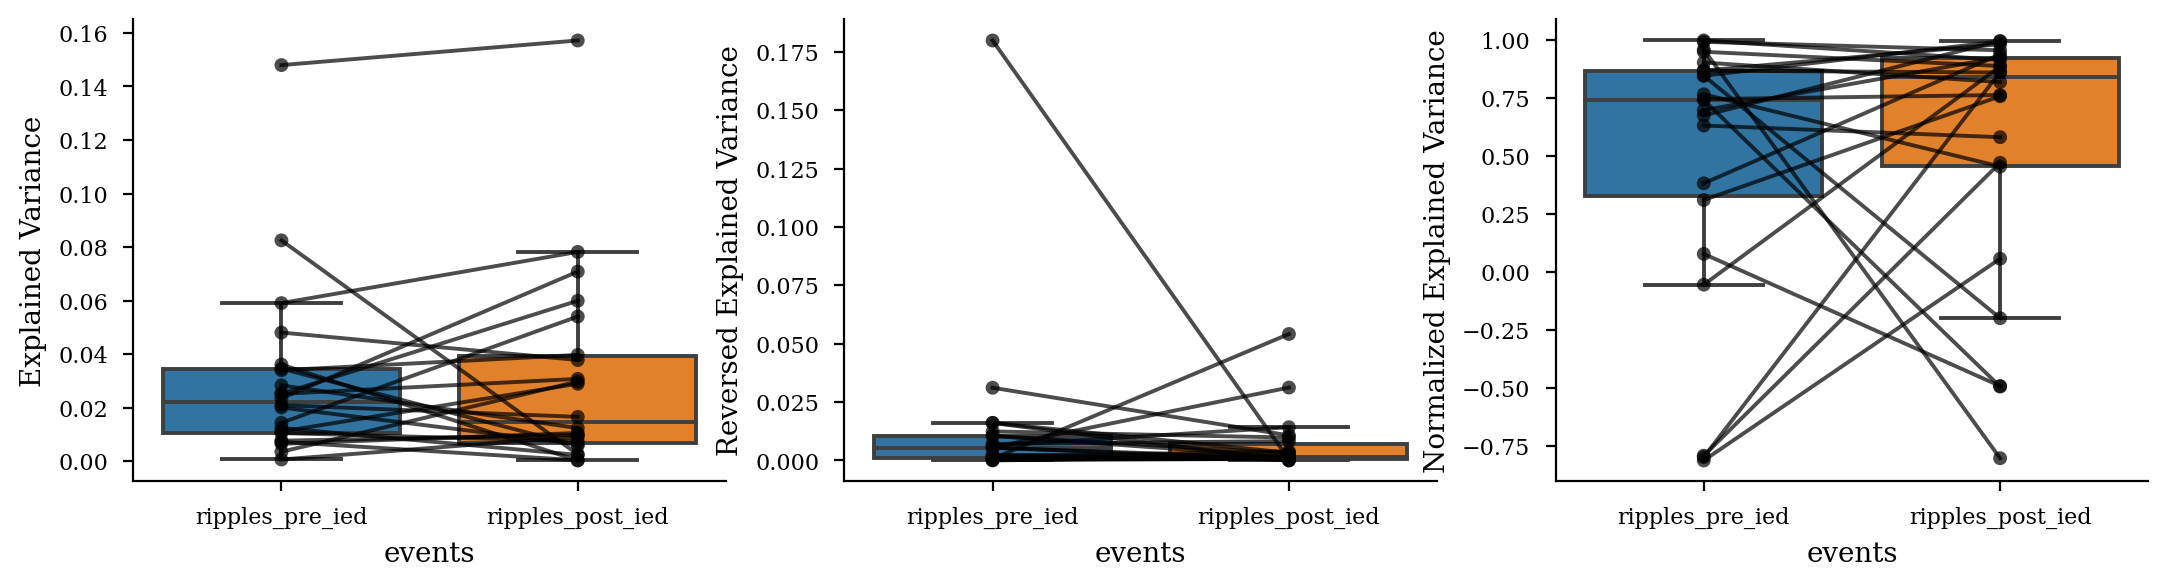

In [80]:
vars = ["ev", "rev", "ev_norm"]
fig,ax = plt.subplots(1,3,figsize=(13,3))
for var in vars:
    sns.boxplot(
        data=ev_df,
        x="events",
        y=var,
        showfliers=False,
        ax=ax[vars.index(var)],
    )
    sns.lineplot(
        y=var,
        x="events",
        data=ev_df,
        units="basepath",
        estimator=None,
        color="k",
        alpha=.7,
        legend=True,
        ax=ax[vars.index(var)],
        zorder = 1000,
    )

    sns.stripplot(
        data=ev_df,
        x="events",
        y=var,
        color="k",
        jitter=False,
        size=5,
        alpha=.7,
        ax=ax[vars.index(var)],
    )
ax[0].set_ylabel("Explained Variance")
ax[1].set_ylabel("Reversed Explained Variance")
ax[2].set_ylabel("Normalized Explained Variance")
sns.despine()

In [72]:
ev_df.query("events=='ripples_pre_ied'").shape, ev_df.query("events=='ripples_post_ied'").shape

((22, 10), (22, 10))

In [73]:
# do paired t-tests between ripples_pre_ied and ripples_post_ied for variable ev

from scipy import stats
stats.ttest_rel(ev_df.query("events=='ripples_pre_ied'").ev.values, ev_df.query("events=='ripples_post_ied'").ev.values)

Ttest_relResult(statistic=-0.08851520730163452, pvalue=0.9303059018522197)

In [83]:
stats.ttest_rel(ev_df.query("events=='ripples_pre_ied'").ev_norm.values, ev_df.query("events=='ripples_post_ied'").ev_norm.values)


Ttest_relResult(statistic=-0.3597416307686813, pvalue=0.7226327919201703)

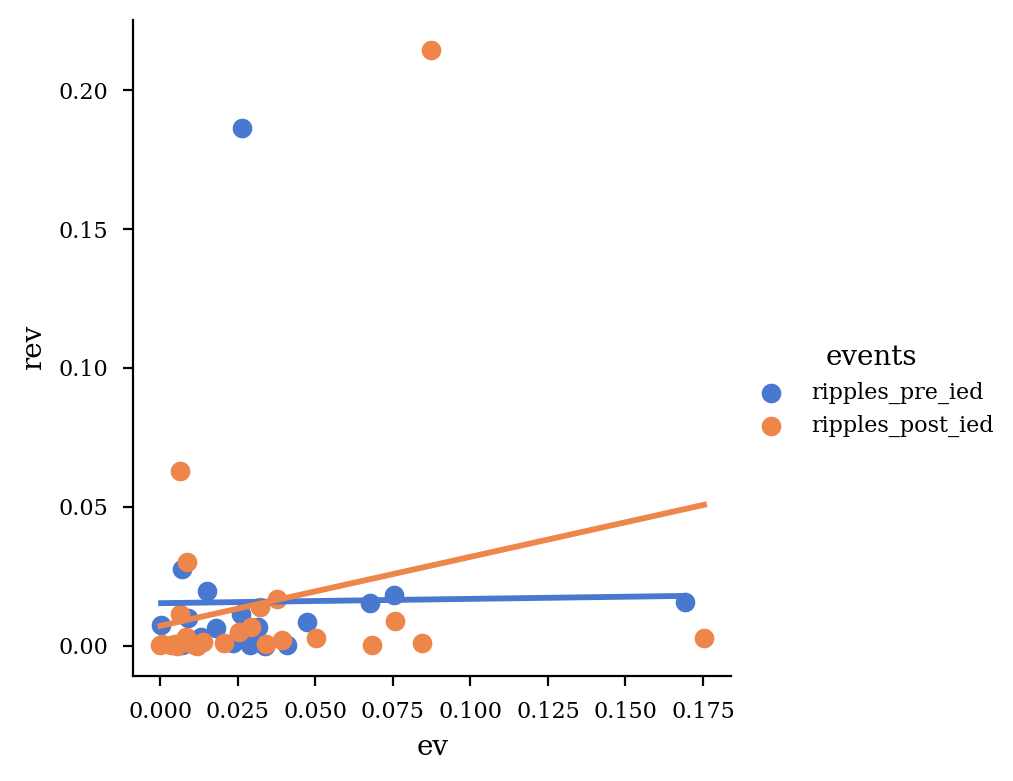

In [21]:
sns.lmplot(x="ev", y="rev", hue="events", data=ev_df,
           ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})